### Code 11.64

In [25]:
import pandas as pd
import arviz as az
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from pytensor import tensor as T

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [2]:
d = pd.read_csv("./Data/AustinCats.csv", delimiter=";")
d["adopt"] = 1
d.adopt = d.adopt.where(d.out_event == "Adoption", 0)
d["color_id"] = 0
d.color_id = d.color_id.where(d.color == "Black", 1)

d_obs = d[d.adopt == 1]
d_cens = d[d.adopt == 0]

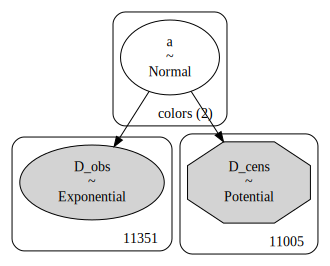

In [9]:
from pymc.math import exp

coords = {"colors": ["black", "non-black"]}
    
with pm.Model(coords=coords) as m11_14:
    a = pm.Normal("a", mu=0, sigma=1, dims="colors")
    
    mu_obs = exp(a[d_obs.color_id])
    likelihood_obs = pm.Exponential("D_obs", lam=1/mu_obs, observed=d_obs.days_to_event)
    
    mu_cens = exp(a[d_cens.color_id])
    exp_lccdf = -1/mu_cens * d_cens.days_to_event
    likelihood_cens = pm.Potential("D_cens", exp_lccdf)
    
pm.model_to_graphviz(m11_14)

In [4]:
with m11_14:
    trace11_14 = pm.sample(chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [5]:
az.summary(trace11_14, var_names=["a"], round_to=2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a[black],4.05,0.03,4.00,4.1
a[non-black],3.88,0.01,3.86,3.9


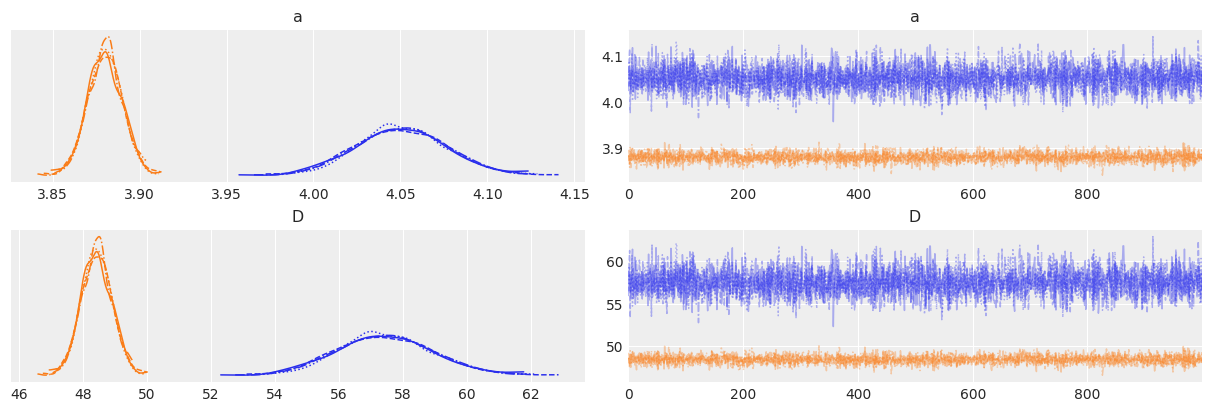

In [15]:
az.plot_trace(trace11_14);

In [7]:
trace11_14.posterior["D"] = np.exp(trace11_14.posterior.a)

In [8]:
az.summary(trace11_14, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
a[black],4.05,0.03,4.00,4.10
a[non-black],3.88,0.01,3.86,3.90
D[black],57.46,1.47,54.70,60.18
D[non-black],48.43,0.47,47.59,49.36


In [99]:
diff_a = post_a[0, :] - post_a[1, :]
az.summary({"diff_a": diff_a}, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
diff_a,0.17,0.03,0.12,0.23


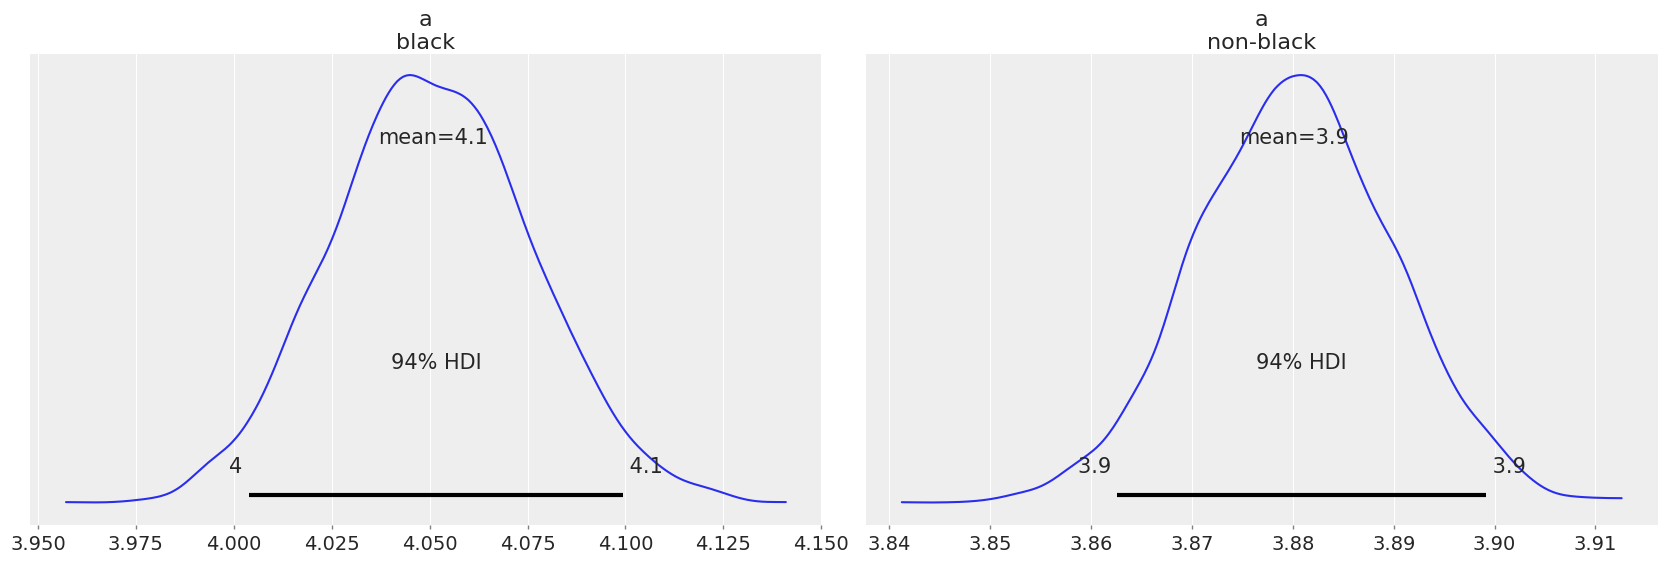

In [17]:
az.plot_posterior(trace11_14, var_names=["a"]);

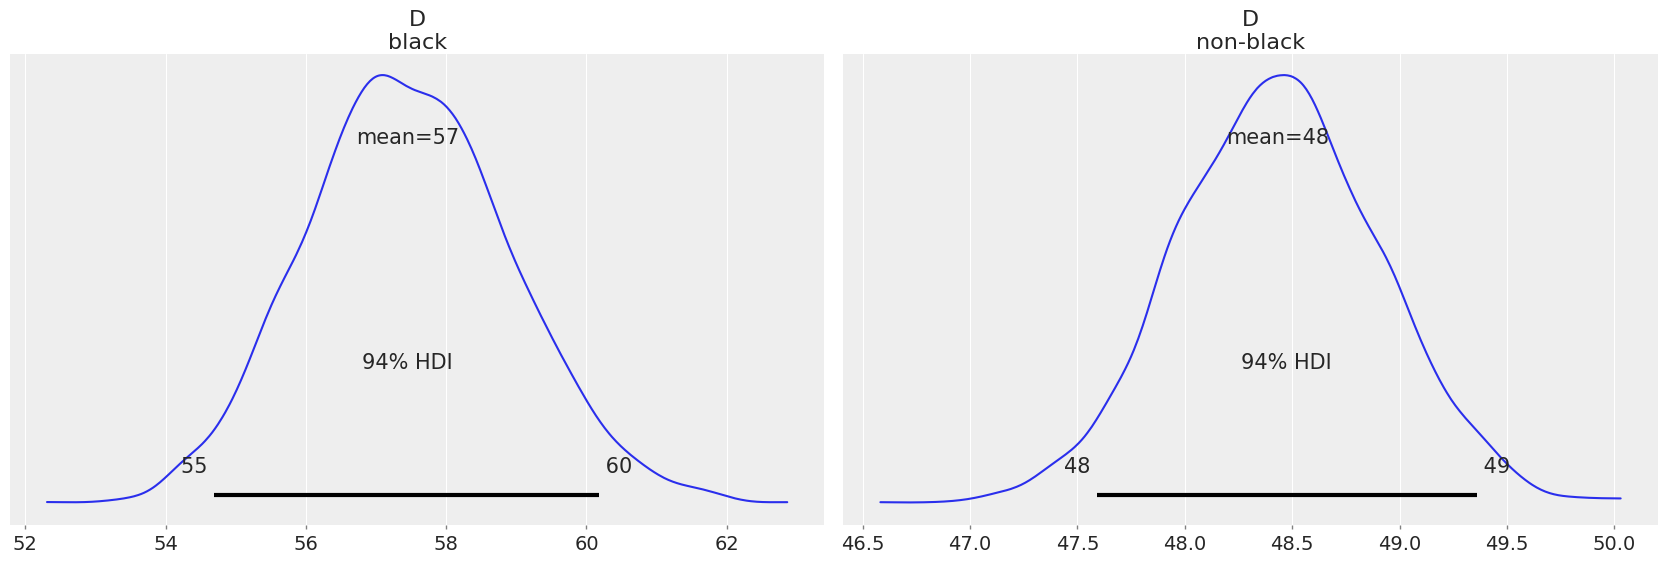

In [18]:
az.plot_posterior(trace11_14, var_names=["D"]);

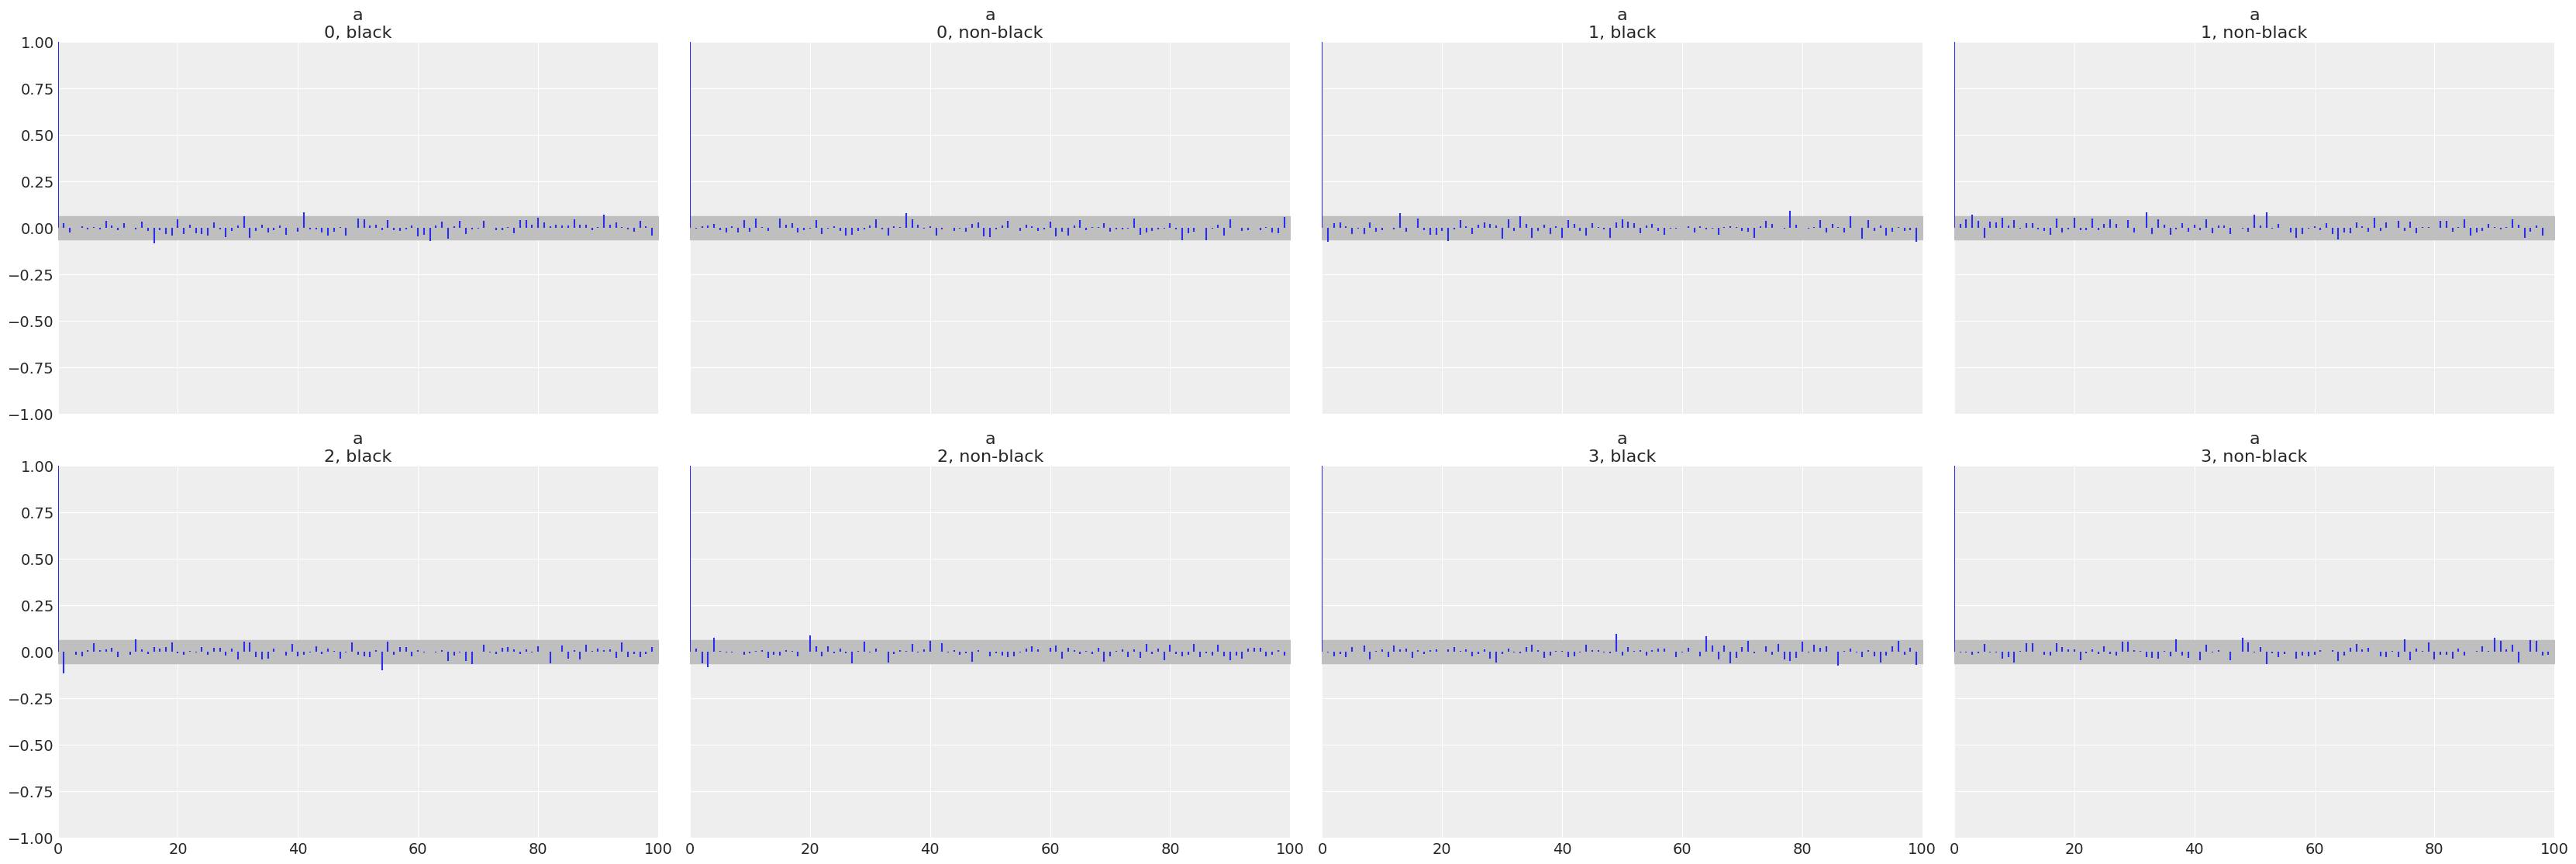

In [20]:
az.plot_autocorr(trace11_14, var_names=["a"]);

### Cox's proportional hazards model

In [146]:
interval_length = 50
interval_bounds = np.arange(0, d.days_to_event.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)

In [147]:
d.adopt.mean()

0.5077384147432457

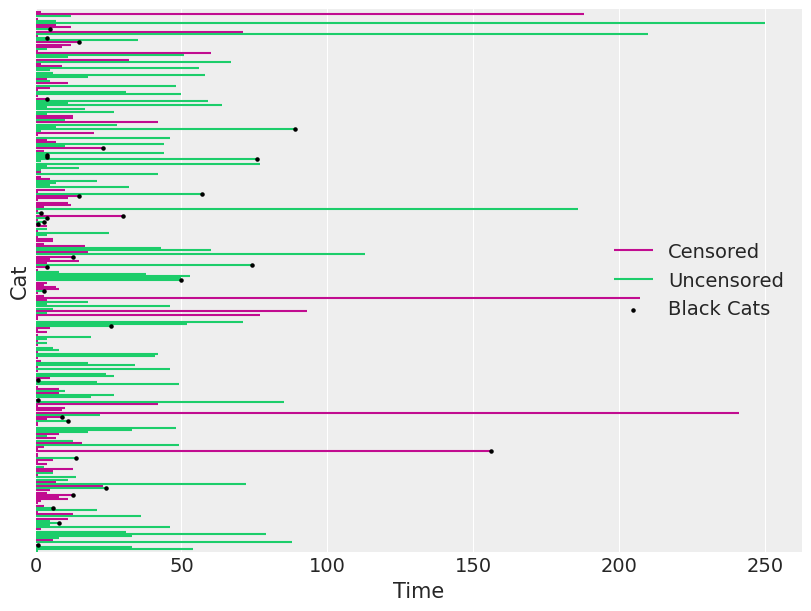

In [148]:
fig, ax = plt.subplots(figsize=(8, 6))

sample_s = 250
cats = np.arange(sample_s)
sd = d.sample(sample_s)

ax.hlines(
    cats[sd.adopt == 0], 0, sd[sd.adopt == 0].days_to_event, color="C3", label="Censored"
)

ax.hlines(
    cats[sd.adopt == 1], 0, sd[sd.adopt == 1].days_to_event, color="C7", label="Uncensored"
)

ax.scatter(
    sd[sd.color_id == 0].days_to_event,
    cats[sd.color_id == 0],
    color="k",
    zorder=10,
    s=5,
    label="Black Cats",
)

ax.set_xlim(left=0)
ax.set_xlabel("Time")
ax.set_yticks([])
ax.set_ylabel("Cat")

ax.set_ylim(-0.25, sample_s + 0.25)

ax.legend(loc="center right");

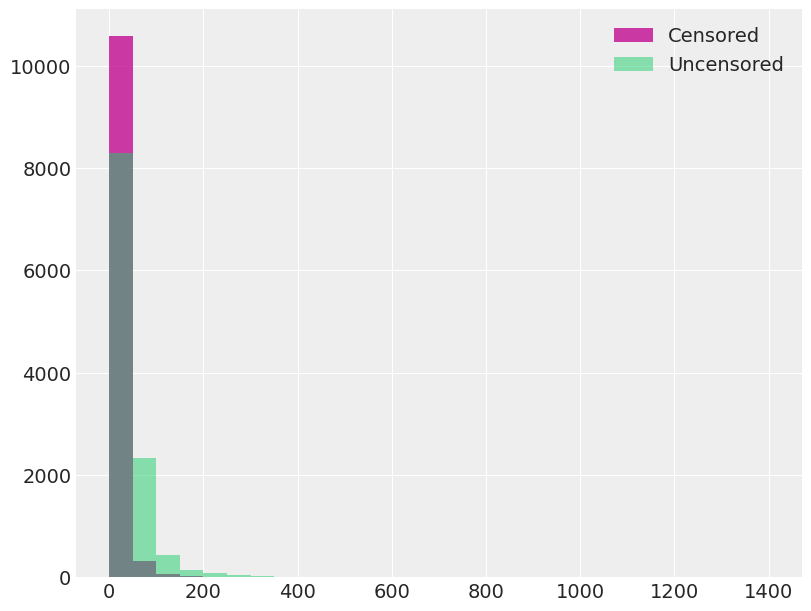

In [149]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(
    d[d.adopt == 0].days_to_event.values,
    bins=interval_bounds,
    lw=0,
    color="C3",
    alpha=0.8,
    label="Censored",
)

ax.hist(
    d[d.adopt == 1].days_to_event.values,
    bins=interval_bounds,
    lw=0,
    color="C7",
    alpha=0.5,
    label="Uncensored",
)

ax.legend();

In [150]:
last_period = np.floor((d.days_to_event - 0.01) / interval_length).astype(int)

In [151]:
n_cats = len(d)
cats = np.arange(n_cats)
adoption = np.zeros((n_cats, n_intervals))
adoption[cats, last_period] = d.adopt

In [152]:
adoption.shape

(22356, 28)

In [153]:
exposure = np.greater_equal.outer(d.days_to_event.to_numpy(), interval_bounds[:-1]) * interval_length
exposure[cats, last_period] = d.days_to_event - interval_bounds[last_period]

In [155]:
from pytensor import tensor as T

coords = {"intervals": intervals, "colors": ["black", "non-black"]}

with pm.Model(coords=coords) as model:
    lambda0 = pm.Gamma("lambda0", 0.01, 0.01, dims="intervals")
    a = pm.Normal("a", 0, sigma=1000, dims="colors")
    lambda_ = T.outer(T.exp(a[d.color_id]), lambda0)
    # from exp to poisson dist: given a time window, count the occurence of events whose durations are exp. distributed
    mu = exposure * lambda_
    obs = pm.Poisson("obs", mu, observed=adoption)

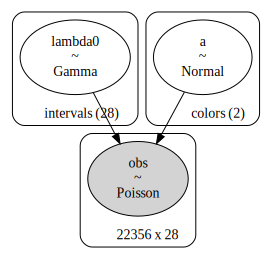

In [156]:
pm.model_to_graphviz(model)

In [157]:
n_samples = 1000
n_tune = 1000

with model:
    idata = pm.sample(
        #n_samples,
        #tune=n_tune,
        #target_accept=0.99,
        random_seed=RANDOM_SEED,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda0, a]


ValueError: Not enough samples to build a trace.

In [49]:
hazard = trace11_14.posterior.D
black_hazard = hazard[:, :, 0]
non_black_hazard = hazard[:, :, 1]

In [51]:
def cum_hazard(hazard):
    return (interval_length * hazard).cumsum(axis=-1)


def survival(hazard):
    return np.exp(-cum_hazard(hazard))


def get_mean(trace):
    return trace.mean(("chain", "draw"))

In [57]:
cum_hazard(black_hazard).shape

(4, 1000)

In [59]:
np.exp(-cum_hazard(black_hazard)).shape

(4, 1000)

In [60]:
interval_bounds[:-1]

array([   0,    1,    2, ..., 1360, 1361, 1362])

/home/jaredxfeng/.local/share/virtualenvs/rethinking-JoO_cdOo/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


TypeError: Dimension mismatch for x: (1363,) and hdi: (1000, 2). Check the dimensions of y andhdi_kwargs to make sure they are compatible

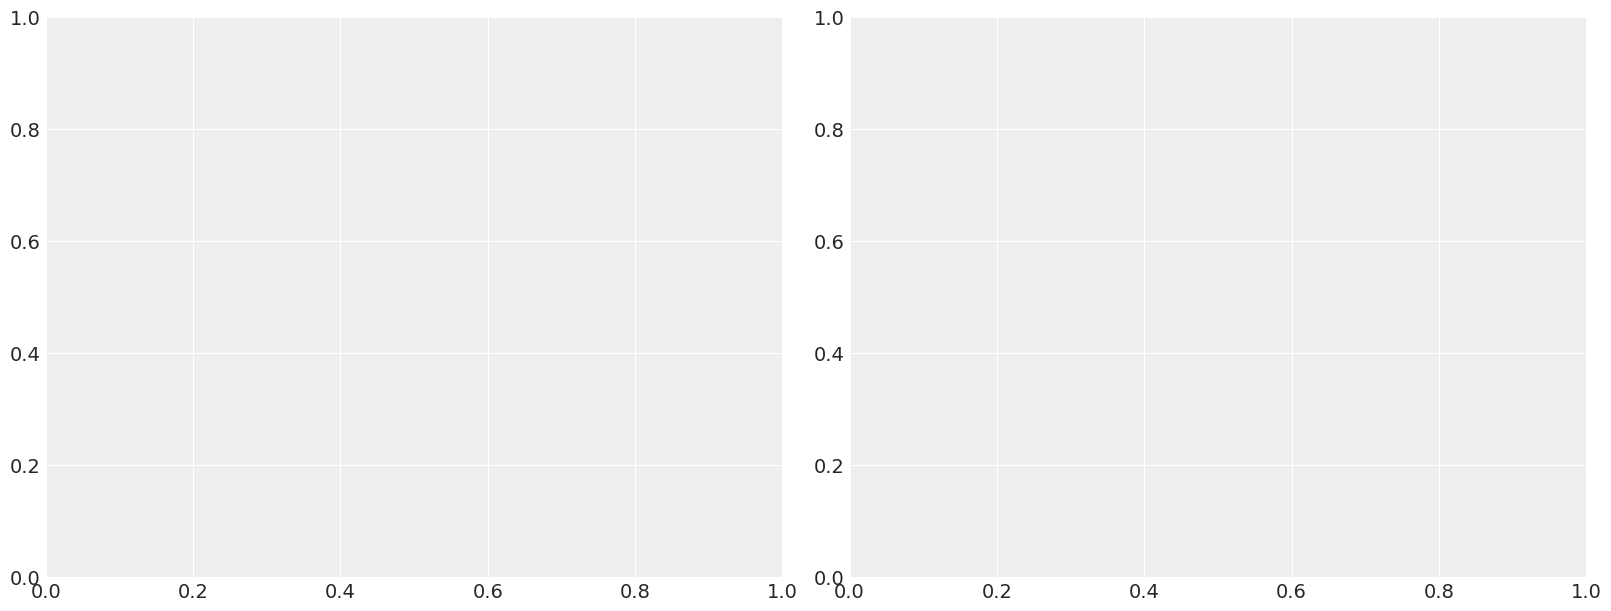

In [52]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

az.plot_hdi(
    interval_bounds[:-1],
    cum_hazard(black_hazard),
    ax=hazard_ax,
    smooth=False,
    color="C0",
    fill_kwargs={"label": "Had not metastasized"},
)

az.plot_hdi(
    interval_bounds[:-1],
    cum_hazard(non_black_hazard),
    ax=hazard_ax,
    smooth=False,
    color="C1",
    fill_kwargs={"label": "Metastasized"},
)
